In [1]:
from skimage.filters import threshold_local
from scipy.spatial import distance as dist
import numpy as np
import pandas as pd
import cv2
import imutils
from imutils import contours
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def order_points(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    return np.array([tl, tr, br, bl], dtype="float32")

In [3]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([ [0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [4]:
def perspective_transform(image):
    ratio = image.shape[0] / 650.0
    orig_image = image.copy()
    image = imutils.resize(image, height = 650)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
#     print(approx)
        if len(approx) == 4:
            screenCnt = approx
            break
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    warped = four_point_transform(orig_image, screenCnt.reshape(4, 2) * ratio)
    return orig_image, edged, image, warped

In [5]:
def get_contours_with_gaussian(img, kernel, thr=[50, 70], ita_dia=1, ita_erod=1):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, kernel, 0)
    img_canny = cv2.Canny(img_blur, thr[0], thr[1])
    sq_kernel = np.ones((5,5))
    img_dia = cv2.dilate(img_canny, None, ita_dia)
    img_thrld = cv2.erode(img_dia, None, ita_erod)
    contours = cv2.findContours(img_thrld.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    (final_contours, _) = imutils.contours.sort_contours(contours)
    plt.figure(figsize=(10,8)), plt.imshow(img_thrld, 'gray'), plt.title('Edges Detected By Canny Edge Algorithm')
    return final_contours

In [6]:
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),(255, 0, 255))

In [7]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [8]:
def get_size(image, box, pixel_per_cm):
    (tl, tr, br, bl) = box
    mid_pt_horizontal = (tl[0] + int(abs(tr[0] - tl[0])/2), tl[1] + int(abs(tr[1] - tl[1])/2))
    mid_pt_verticle = (tr[0] + int(abs(tr[0] - br[0])/2), tr[1] + int(abs(tr[1] - br[1])/2))
    wid = dist.euclidean(tl, tr)/pixel_per_cm
    ht = dist.euclidean(tr, br)/pixel_per_cm
    if wid >=12:
        cv2.putText(image, "{:.1f}cm".format(wid), (int(mid_pt_horizontal[0] - 15), int(mid_pt_horizontal[1] - 150)), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        cv2.putText(image, "{:.1f}cm".format(ht), (int(mid_pt_verticle[0] - 30), int(mid_pt_verticle[1])), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    else:
        cv2.putText(image, "{:.1f}cm".format(wid), (int(mid_pt_horizontal[0] - 15), int(mid_pt_horizontal[1] - 10)), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        cv2.putText(image, "{:.1f}cm".format(ht), (int(mid_pt_verticle[0] + 10), int(mid_pt_verticle[1])), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    print(wid,ht)

In [9]:
def get_distance(resizedImg, cnts, refObj_width, tune,measure_size = True, measure_distance = True, refObj=None):
    orig = resizedImg.copy()
    for c in cnts:
        
        if cv2.contourArea(c) < tune:
            continue
            
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = np.array(box)
    
        box = order_points(box)

        cX = np.average(box[:, 0])
        cY = np.average(box[:, 1])

        if refObj is None:
            (tl, tr, br, bl) = box
            (tlblX, tlblY) = midpoint(tl, bl)
            (trbrX, trbrY) = midpoint(tr, br)
            D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
            refObj = (box, (cX, cY), D / refObj_width) 

            continue
        
        
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
        cv2.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)

        refCoords = np.vstack([refObj[0], refObj[1]])
        objCoords = np.vstack([box, (cX, cY)])
        
        if measure_size:
            mid_pt_horizontal = (tl[0] + int(abs(tr[0] - tl[0])/2), tl[1] + int(abs(tr[1] - tl[1])/2))
            mid_pt_verticle = (tr[0] + int(abs(tr[0] - br[0])/2), tr[1] + int(abs(tr[1] - br[1])/2))
            wid = dist.euclidean(tl, tr)/refObj[2]
            ht = dist.euclidean(tr, br)/refObj[2]
            cv2.putText(orig, "{:.1f}cm".format(wid), (int(mid_pt_horizontal[0] - 15), int(mid_pt_horizontal[1] - 10)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(orig, "{:.1f}cm".format(ht), (int(mid_pt_verticle[0] + 10), int(mid_pt_verticle[1])), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2) 
            get_size(orig, box, refObj[2]) 
        
        if measure_distance:
            for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
                cv2.circle(orig, (int(xA), int(yA)), 5, color, -1)
                cv2.circle(orig, (int(xB), int(yB)), 5, color, -1)
                cv2.line(orig, (int(xA), int(yA)), (int(xB), int(yB)), color, 2)
                D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
                (mX, mY) = midpoint((xA, yA), (xB, yB))
                cv2.putText(orig, "{:.1f}in".format(D), (int(mX), int(mY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
#             plt.figure(figsize=(12,10))
#             plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    return orig

In [10]:
accuracy_pd = pd.read_excel('accuracy_test.xlsx', header=None)
accuracy_pd.columns = accuracy_pd.iloc[1]
heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]
dfstyle = [dict(selector="th", props=heading_properties),dict(selector="td", props=cell_properties)]

## Image01 - With Perspective Transformation

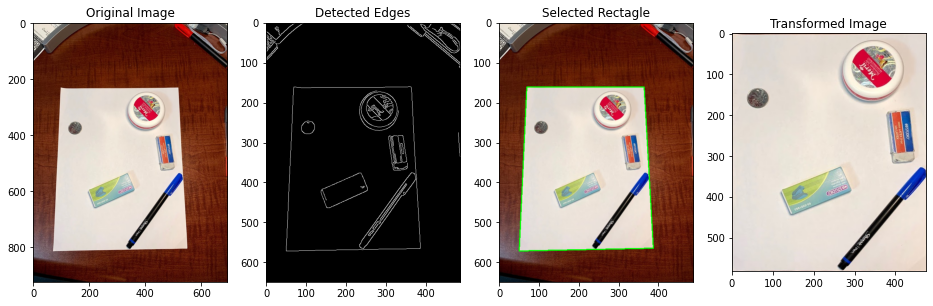

In [11]:
img1 = cv2.imread('./dataset/img1.jpg')
img1_orig, img1_edged, img1_selected_, img1_warped = perspective_transform(img1)
plt.figure(figsize=(16,12))
plt.subplot(141), plt.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(142), plt.imshow(img1_edged, 'gray'), plt.title('Detected Edges')
plt.subplot(143), plt.imshow(cv2.cvtColor(img1_selected_, cv2.COLOR_BGR2RGB)), plt.title('Selected Rectagle')
plt.subplot(144), plt.imshow(cv2.cvtColor(img1_warped, cv2.COLOR_BGR2RGB)), plt.title('Transformed Image')
plt.show()

7.581125973041241 3.2064150854257436
14.693491241455076 1.3626927324441762
7.217916310237004 7.010216273381159
2.743028984069824 6.052141736544095


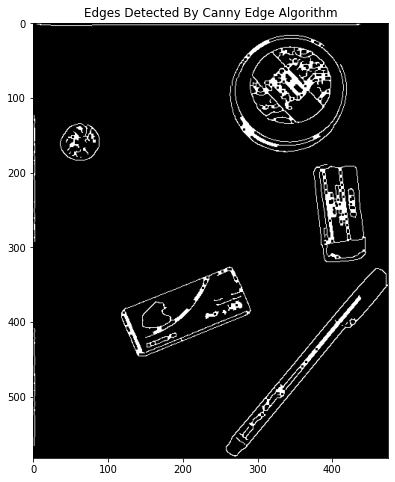

In [12]:
img1_cntrs_gaussian = get_contours_with_gaussian(img1_warped,(7,7))
img1_size_measurement = get_distance(img1_warped, img1_cntrs_gaussian, 2.388,tune=1000, measure_distance=False)
img1_distance_measurement = get_distance(img1_warped, img1_cntrs_gaussian, 2.388,tune=1000, measure_size=False)

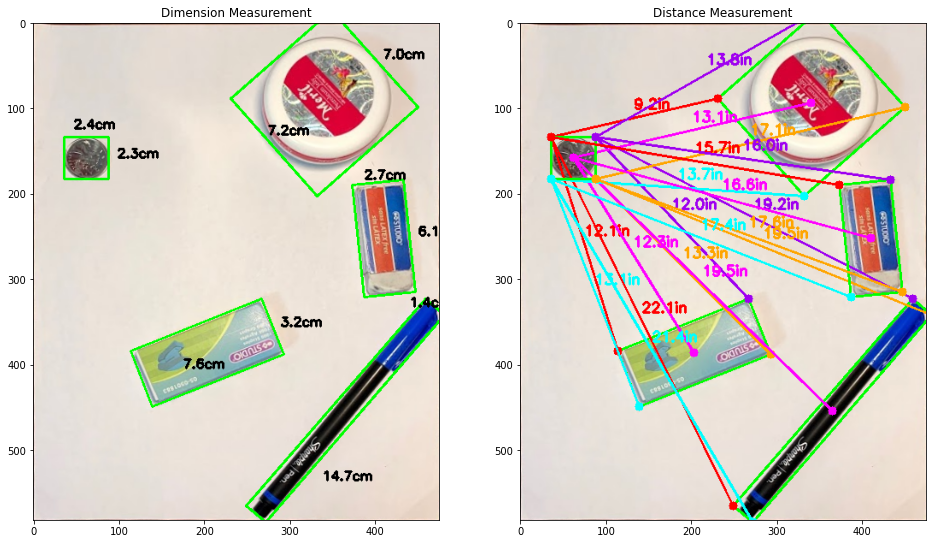

In [46]:
plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1_size_measurement, cv2.COLOR_BGR2RGB)), plt.title('Dimension Measurement')
plt.subplot(122), plt.imshow(cv2.cvtColor(img1_distance_measurement, cv2.COLOR_BGR2RGB)), plt.title('Distance Measurement')
plt.show()

### Accuracy Test: Objects'  Dimension Measurement for Image1 with Perspective Transformation

In [14]:
for_img1 = accuracy_pd[2:7]
for_img1.style.set_table_styles(dfstyle).set_caption('Object Measurement in Img1 with Perspective Transformation').set_precision(2).hide_index()

## Image1 - Without Perspective Transformation

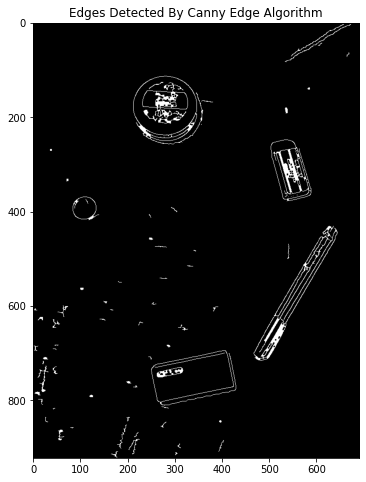

In [15]:
img12 = cv2.imread('./dataset/img12.jpg')
img12_cntrs_gaussian = get_contours_with_gaussian(img12, kernel=(7, 7), thr=[30, 60], ita_dia=3, ita_erod=2)

6.76012197392944 6.992449402937045
8.108424752673013 4.2870757197934815
15.3476448232599 1.6610757133759073
2.9867737003618955 6.162229145312562


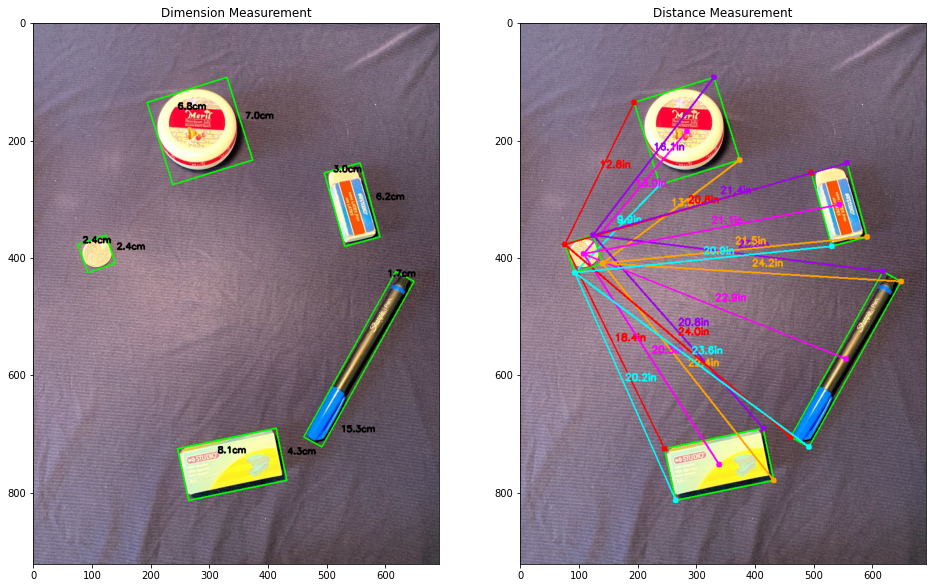

In [45]:
img12_size_measurement = get_distance(img12, img12_cntrs_gaussian, 2.388,tune=350, measure_distance=False)
img12_distance_measurement = get_distance(img12, img12_cntrs_gaussian, 2.388,tune=1000, measure_size=False)
plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img12_size_measurement, cv2.COLOR_BGR2RGB)), plt.title('Dimension Measurement')
plt.subplot(122), plt.imshow(cv2.cvtColor(img12_distance_measurement, cv2.COLOR_BGR2RGB)), plt.title('Distance Measurement')
plt.show()

> ### Accuracy Test: Objects' Dimension Measurement with Perspective Transformation

In [17]:
for_img11 = accuracy_pd[9:14]
for_img11.style.set_table_styles(dfstyle).set_caption('Object Measurement in Img11 without Perspective Transformation').set_precision(2).hide_index()

## Image2 - With Perspective Transformation

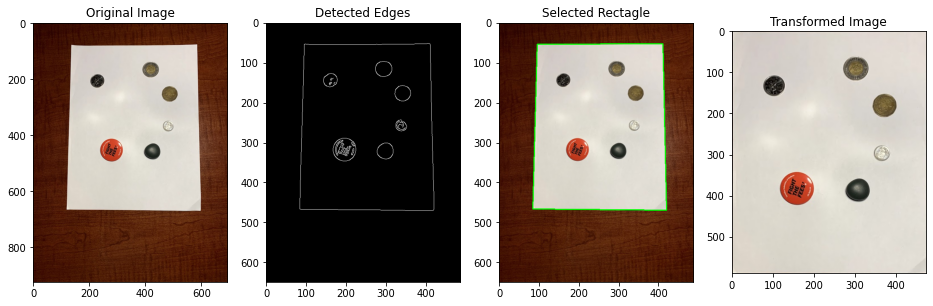

In [18]:
img2 = cv2.imread('./dataset/img2.jpg')
img2_orig, img2_edged, img2_selected_, img2_warped = perspective_transform(img2)
plt.figure(figsize=(16,12))
plt.subplot(141), plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(142), plt.imshow(img2_edged, 'gray'), plt.title('Detected Edges')
plt.subplot(143), plt.imshow(cv2.cvtColor(img2_selected_, cv2.COLOR_BGR2RGB)), plt.title('Selected Rectagle')
plt.subplot(144), plt.imshow(cv2.cvtColor(img2_warped, cv2.COLOR_BGR2RGB)), plt.title('Transformed Image')
plt.show()

3.8395294117647056 3.745882352941176
2.9030588235294115 2.5752941176470587
2.7157647058823526 2.622117647058823
2.668941176470588 2.622117647058823
1.9524878055348116 1.6675741738712087


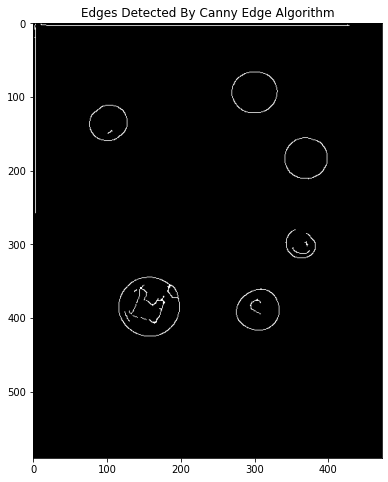

In [19]:
img2_cntrs_gaussian = get_contours_with_gaussian(img2_warped, kernel=(15, 15), thr=[50, 70], ita_dia=1, ita_erod=1)
img2_size_measurement = get_distance(img2_warped, img2_cntrs_gaussian, 2.388,tune=20, measure_distance=False)
img2_distance_measurement = get_distance(img2_warped, img2_cntrs_gaussian, 2.388,tune=20, measure_size=False)

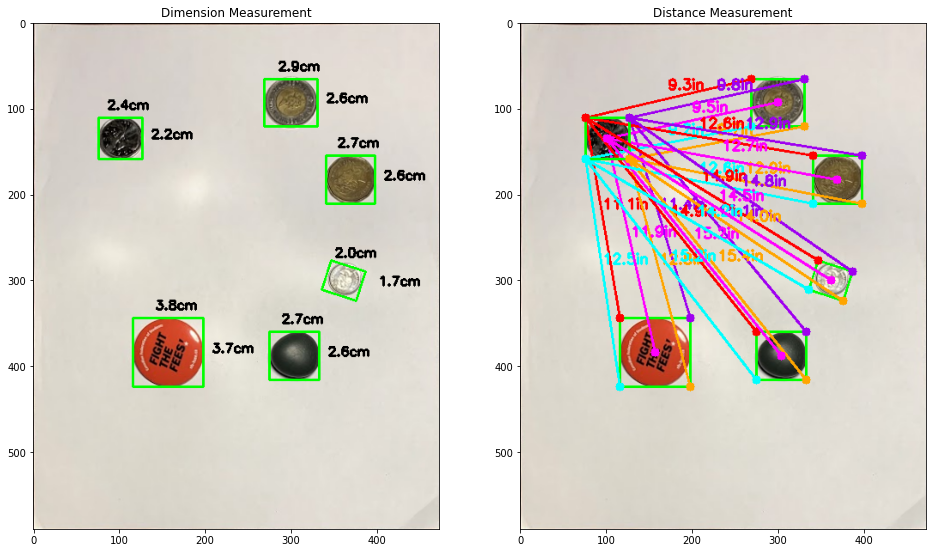

In [44]:
plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img2_size_measurement, cv2.COLOR_BGR2RGB)), plt.title('Dimension Measurement')
plt.subplot(122), plt.imshow(cv2.cvtColor(img2_distance_measurement, cv2.COLOR_BGR2RGB)), plt.title('Distance Measurement')
plt.show()

> ### Accuracy Test: Objects' Dimension Measurement with Perspective Transformation

In [21]:
for_img2 = accuracy_pd[16:22]
for_img2.style.set_table_styles(dfstyle).set_caption('Object Measurement in Img2 with Perspective Transformation').set_precision(2).hide_index()

## Image2-Without Perspective Transformation

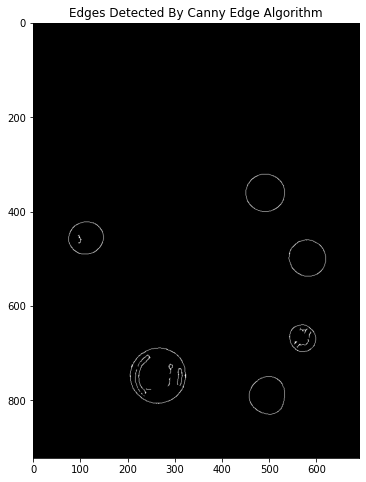

In [22]:
img22 = cv2.imread('./dataset/img22.jpg')
img22_cntrs_gaussian = get_contours_with_gaussian(img22, kernel=(21, 21), thr=[30, 50], ita_dia=3, ita_erod=1)

3.8050689326105887 2.918414008063239
2.646162162162162 2.5493513513513513
2.42027027027027 2.5816216216216215
2.517081081081081 2.4848108108108105
1.8711192577465159 1.7570266230815164


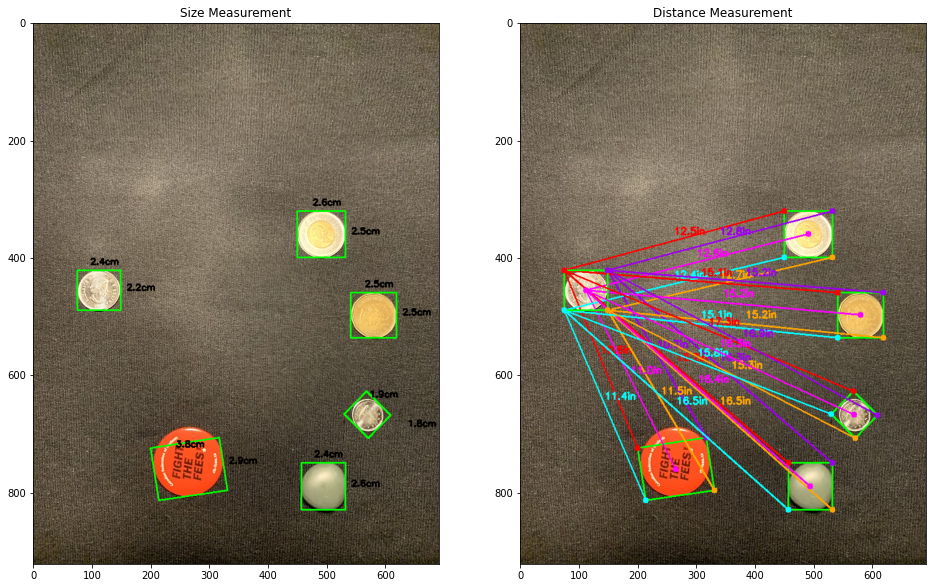

In [43]:
img22_size_measurement = get_distance(img22, img22_cntrs_gaussian, 2.388,tune=50, measure_distance=False)
img22_distance_measurement = get_distance(img22, img22_cntrs_gaussian, 2.388,tune=50, measure_size=False)
plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img22_size_measurement, cv2.COLOR_BGR2RGB)), plt.title('Size Measurement')
plt.subplot(122), plt.imshow(cv2.cvtColor(img22_distance_measurement, cv2.COLOR_BGR2RGB)), plt.title('Distance Measurement')
plt.show()

In [24]:
for_img22 = accuracy_pd[32:37]
for_img22.style.set_table_styles(dfstyle).set_caption('Object Measurement in Img22 without Perspective Transformation').set_precision(2).hide_index()

## Image3 - With Perspective Transformation

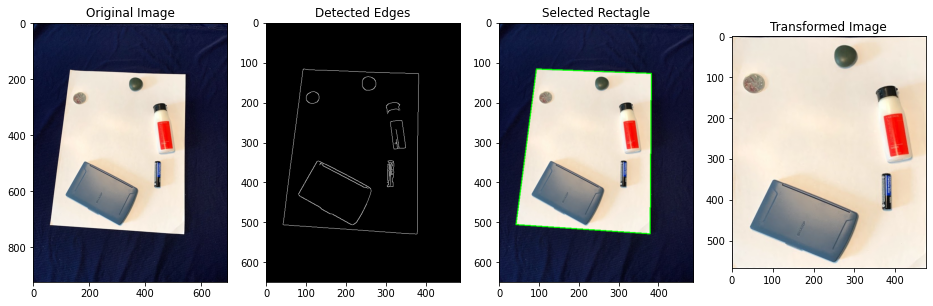

In [39]:
img3 = cv2.imread('./dataset/img3.jpg')
img3_orig, img3_edged, img3_selected_, img3_warped = perspective_transform(img3)
plt.figure(figsize=(16,12))
plt.subplot(141), plt.imshow(cv2.cvtColor(img3_orig, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(142), plt.imshow(img3_edged, 'gray'), plt.title('Detected Edges')
plt.subplot(143), plt.imshow(cv2.cvtColor(img3_selected_, cv2.COLOR_BGR2RGB)), plt.title('Selected Rectagle')
plt.subplot(144), plt.imshow(cv2.cvtColor(img3_warped, cv2.COLOR_BGR2RGB)), plt.title('Transformed Image')
plt.show()

10.812192011995135 6.283733829138413
2.5231698113207544 2.5231698113207544
2.4742784530351742 1.619562874560086
1.0363018867924527 4.055094339622641
2.107479397179945 4.647798438306125


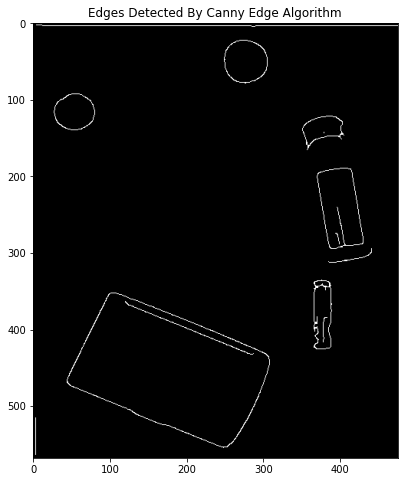

In [26]:
img3_cntrs_gaussian = get_contours_with_gaussian(img3_warped, kernel=(15, 15), thr=[50, 70], ita_dia=3, ita_erod=1)
img3_size_measurement = get_distance(img3_warped, img3_cntrs_gaussian, 2.388,tune=500, measure_distance=False)
img3_distance_measurement = get_distance(img3_warped, img3_cntrs_gaussian, 2.388,tune=200, measure_size=False)

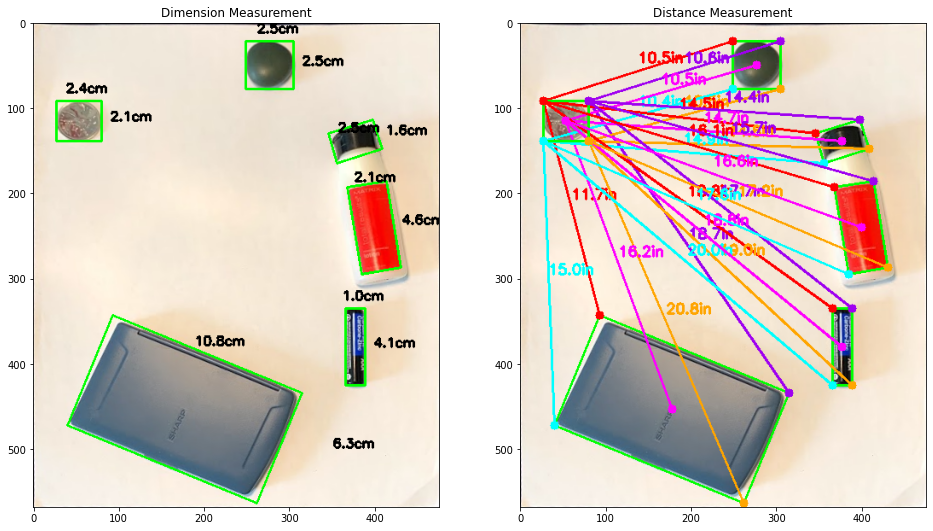

In [42]:
plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img3_size_measurement, cv2.COLOR_BGR2RGB)), plt.title('Dimension Measurement')
plt.subplot(122), plt.imshow(cv2.cvtColor(img3_distance_measurement, cv2.COLOR_BGR2RGB)), plt.title('Distance Measurement')
plt.show()

> ### Accuracy Test: Objects' Dimension Measurement with Perspective Transformation

In [28]:
for_img3 = accuracy_pd[32:37]
for_img3.style.set_table_styles(dfstyle).set_caption('Object Measurement in Img3 with Perspective Transformation').set_precision(2).hide_index()

## Image3 - Without Perspective Transformation

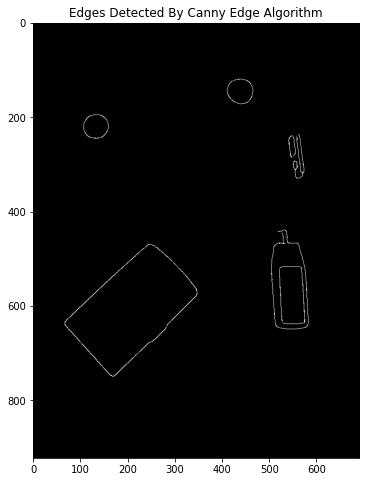

In [29]:
img32 = cv2.imread('./dataset/img32.jpg')
img32_cntrs_gaussian = get_contours_with_gaussian(img32, kernel=(21, 21), thr=[5, 100], ita_dia=1, ita_erod=1)

2.063789650079652 2.02410138757812
2.165808305827236 2.0888029873644673
2.8940762044704655 8.390099661775537
0.8760992730646902 3.679333755591299


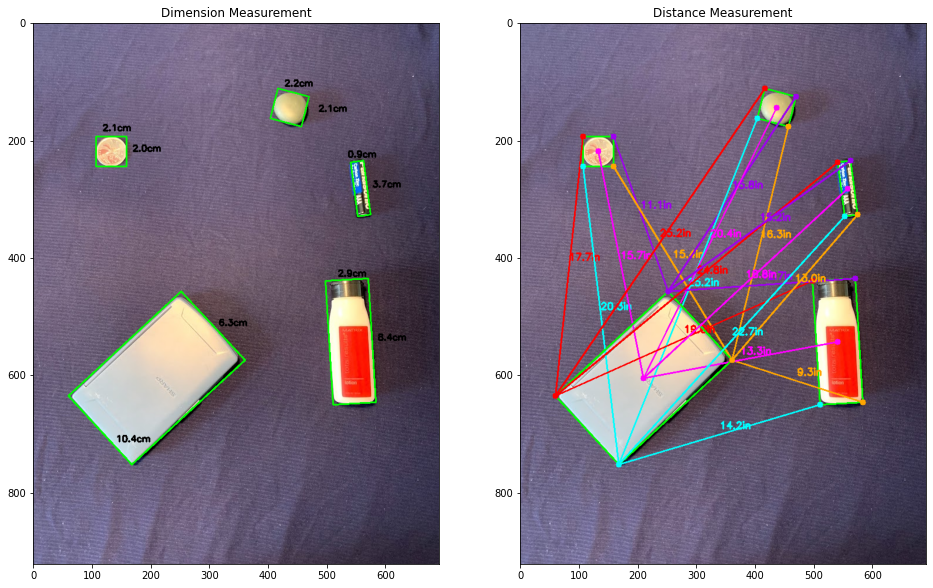

In [41]:
img32_size_measurement = get_distance(img32, img32_cntrs_gaussian, 10.4,tune=40, measure_distance=False)
img32_distance_measurement = get_distance(img32, img32_cntrs_gaussian, 10.4,tune=40, measure_size=False)
plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img32_size_measurement, cv2.COLOR_BGR2RGB)), plt.title('Dimension Measurement')
plt.subplot(122), plt.imshow(cv2.cvtColor(img32_distance_measurement, cv2.COLOR_BGR2RGB)), plt.title('Distance Measurement')
plt.show()

> ### Accuracy Test: Objects' Dimension Measurement without Perspective Transformation

In [31]:
for_img32 = accuracy_pd[39:44]
for_img32.style.set_table_styles(dfstyle).set_caption('Object Measurement in Img32 without Perspective Transformation').set_precision(2).hide_index()

## Image4 - With Perspective Transformation

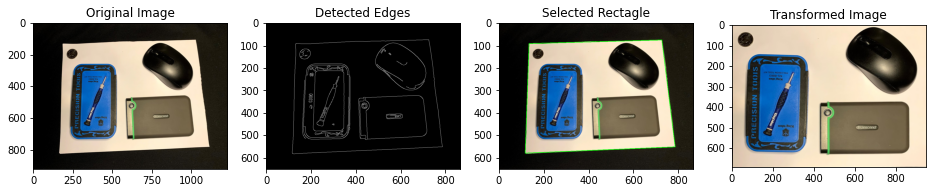

In [32]:
img4 = cv2.imread('./dataset/img4.jpg')
img4_orig, img4_edged, img4_selected_, img4_warped = perspective_transform(img4)
plt.figure(figsize=(16,12))
plt.subplot(141), plt.imshow(cv2.cvtColor(img4_orig, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(142), plt.imshow(img4_edged, 'gray'), plt.title('Detected Edges')
plt.subplot(143), plt.imshow(cv2.cvtColor(img4_selected_, cv2.COLOR_BGR2RGB)), plt.title('Selected Rectagle')
plt.subplot(144), plt.imshow(cv2.cvtColor(img4_warped, cv2.COLOR_BGR2RGB)), plt.title('Transformed Image')
plt.show()

9.84047551393144 15.356786454004826
14.107973183869436 8.278090214321525
11.703522111522604 7.003080416968238


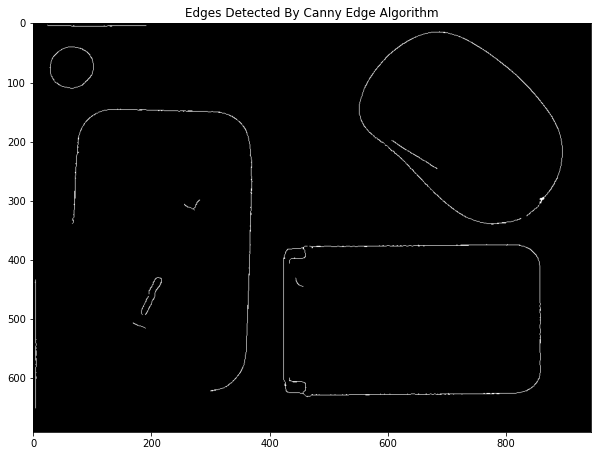

In [33]:
img4_cntrs_gaussian = get_contours_with_gaussian(img4_warped, kernel=(23, 23), thr=[80, 120], ita_dia=1, ita_erod=1)
img4_size_measurement = get_distance(img4_warped, img4_cntrs_gaussian, 2.388,tune=150, measure_distance=False)
img4_distance_measurement = get_distance(img4_warped, img4_cntrs_gaussian, 2.388,tune=150, measure_size=False)

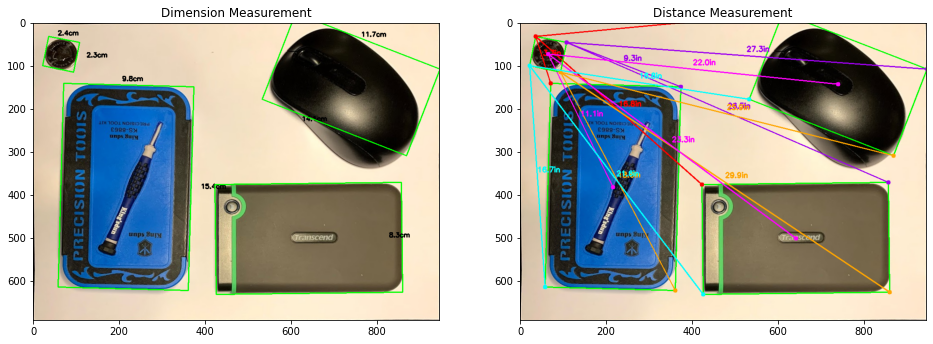

In [40]:
plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img4_size_measurement, cv2.COLOR_BGR2RGB)), plt.title('Dimension Measurement')
plt.subplot(122), plt.imshow(cv2.cvtColor(img4_distance_measurement, cv2.COLOR_BGR2RGB)), plt.title('Distance Measurement')
plt.show()

> ### Accuracy Test: Objects' Dimension Measurement with Perspective Transformation

In [35]:
for_img4 = accuracy_pd[46:50]
for_img4.style.set_table_styles(dfstyle).set_caption('Object Measurement in Img4 with Perspective Transformation').set_precision(2).hide_index()

## Image4 - Without Perspective Transformation

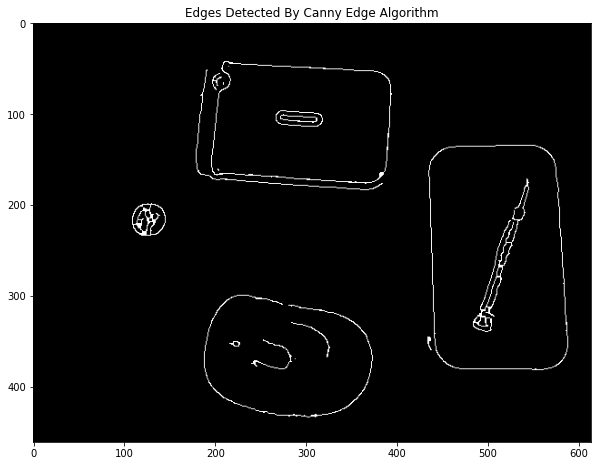

In [36]:
img42 = cv2.imread('./dataset/img42.jpg')
# img42 = imutils.resize(img42, height = 650)
img42 = cv2.resize(img42, (int(img42.shape[1]/2), int(img42.shape[0]/2)), interpolation = cv2.INTER_AREA)
img42_cntrs_gaussian = get_contours_with_gaussian(img42, kernel=(11, 11), thr=[20, 110], ita_dia=3, ita_erod=1)

12.289943440755208 8.223804219563801
12.911175537109376 8.371300252278646
9.800752766927083 16.605418904622397


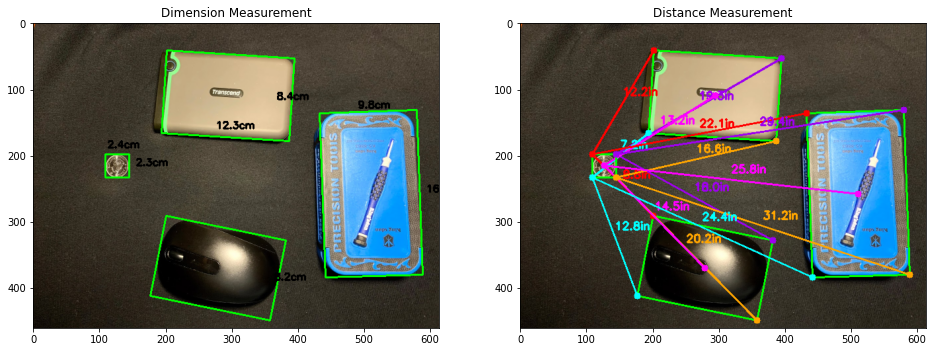

In [37]:
img42_size_measurement = get_distance(img42, img42_cntrs_gaussian, 2.4,tune=60, measure_distance=False)
img42_distance_measurement = get_distance(img42, img42_cntrs_gaussian, 2.4,tune=60, measure_size=False)
plt.figure(figsize=(16,10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img42_size_measurement, cv2.COLOR_BGR2RGB)), plt.title('Dimension Measurement')
plt.subplot(122), plt.imshow(cv2.cvtColor(img42_distance_measurement, cv2.COLOR_BGR2RGB)), plt.title('Distance Measurement')
plt.show()

> ### Accuracy Test: Objects' Dimension Measurement without Perspective Transformation

In [38]:
for_img42 = accuracy_pd[52:56]
for_img42.style.set_table_styles(dfstyle).set_caption('Object Measurement in Img42 without Perspective Transformation').set_precision(2).hide_index()